## Fall 2022 Data Science Intern Challenge

#### Shuaichen Wu

### Question 1: 
Given some sample data, write a program to answer the following:


On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

### First I need to read in all of the data and perform EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv')

In [4]:
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [5]:
df.shape

(5000, 7)

The dataset has 5000 rows and 7 columns.
Each row represents an order.
7 columns describe information about the order.

    order_id : order id
    shop_id : shop id 
    user_id : customer id
    order_amount : the amount of value the customer paid the shop
    total_item : the amount of items the customer bought from the shop.
    payment_method : the method of payment
    created_at : the date of the order

In [6]:
#check if the dataset has duplicated rows
df.duplicated().sum()

0

In [7]:
#check if null value exist in the dataset
df.isnull().sum()

order_id          0
shop_id           0
user_id           0
order_amount      0
total_items       0
payment_method    0
created_at        0
dtype: int64

There are no duplicated rows and values in the dataset.

In [8]:
#check the range of dates of orders
a = df['created_at'].min()
print(f'The earliest date of orders is {a}.')

The earliest date of orders is 2017-03-01 0:08:09.


In [9]:
a = df['created_at'].max()
print(f'The lastest date of orders is {a}.')

The lastest date of orders is 2017-03-30 9:55:00.


The range of order dates is from 2017-03-01 to 2017-03-30. The dataset contains 30 days of orders.

Now I combine the information contained in the question.

There are 100 snearker shops, and each shop sells only one model of shoe.
An AOV over the 30 day window is $3145.13. 

In [10]:
# Verify all the 100 shops are in the dataset.
df['shop_id'].nunique()

100

The dataset has 100 sneaker shops.

In [11]:
# Verify the AOV(average order value)
a = round(df['order_amount'].sum()/df['order_id'].nunique(),2)
print(f'The average order value is {a}.')

The average order value is 3145.13.


##### a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 

First I want to know the distribution of the order values.

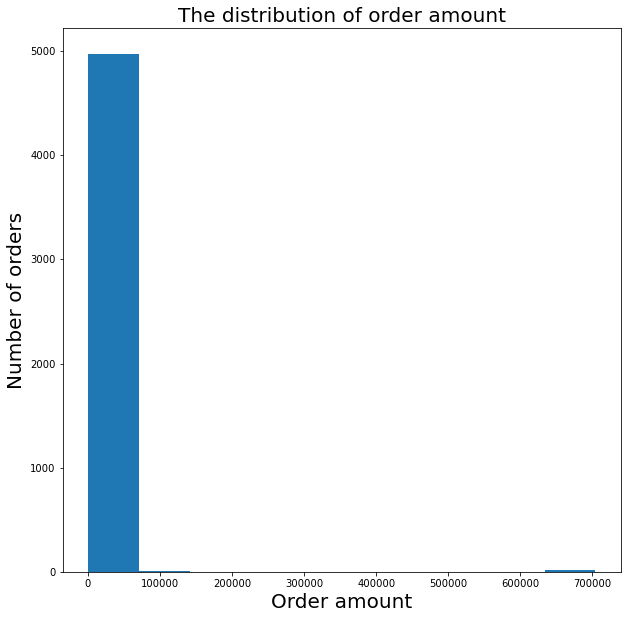

In [12]:
plt.figure(figsize=(10,10))
plt.hist(df['order_amount'])
plt.xlabel('Order amount',size=20)
plt.ylabel('Number of orders',size=20)
plt.title('The distribution of order amount',size=20)
plt.show()

Based on the diagram above, I know the order amounts are pretty skewed, and there are some big values that are around 100,000 and 700,000.

In [13]:
df['order_amount'].describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

The minmum value is 90, while the maximum value is 704,000.
Also, the standard deviation of 41,282 shows the distribution is highly skewed from the mean value.
So the naive mean value of order amount can't show the majority of orders value amount.

There are two main possibilities that the maximum value is so high:

1) There are some high-end sneaker shops.
2) There are some orders that contain a lot of items.

For the first situation, since each shop sells one model of shoes, I can get the estimated value of a single pair of shoes for every shop.

In [14]:
#get the unit value of shoes
df['item_value']=df['order_amount']/df['total_items']

In [15]:
#verify I added the item_value column in the dataset
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,item_value
0,1,53,746,224,2,cash,2017-03-13 12:36:56,112.0
1,2,92,925,90,1,cash,2017-03-03 17:38:52,90.0
2,3,44,861,144,1,cash,2017-03-14 4:23:56,144.0
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,156.0
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11,156.0


In [16]:
item_values=df.groupby('shop_id')['item_value'].mean()
item_values=item_values.reset_index()

In [17]:
item_values['item_value'].describe()

count      100.000000
mean       407.990000
std       2557.462906
min         90.000000
25%        132.750000
50%        153.000000
75%        168.250000
max      25725.000000
Name: item_value, dtype: float64

The maximum value of a pair of sneaker shoes is 25725, while the mean value is 407 and the median value is 153.

In [18]:
#check the 99th percentile value
item_values['item_value'].quantile(0.99)

605.7300000001298

99% of sneakers are lower than 605.

In [19]:
#get the id of the shop that sells sneakers that higher than 605
idx = np.where(item_values['item_value'] > 605)[0].tolist()

In [20]:
idx

[77]

In [21]:
item_values.iloc[idx]

,shop_id,item_value
77,78,25725.0


There is only one shop that sells sneakers with a price higher than 605. The shop id is 78 with a sneaker price of \$25,725.

Because of shop 78, the average order value gets highly skewed.

We now do some further analysis of shop 78.

In [22]:
#get the number of sales in 30 days in shop 78.
shop_78_orders = df[df['shop_id']==78]['order_id'].count()

In [23]:
#get the total amount value of sales in shop 78
shop_78 = df[df['shop_id']==78]['order_amount'].sum()

In [24]:
# get the average order value for all the orders in shop 78
shop_78/shop_78_orders

49213.04347826087

In [25]:
#get the percentagethe total sales that shop 78 comprises
shop_78/df['order_amount'].sum()

0.1439559852571978

Shop 78 comprises 14% of the total sales amount due to the high price of their shoes, which will highly skew average price. So, using median as a metric will be more appropriate.


For the second situation, I hypothesize that some orders contain a lot of items. I get the distribution of the total items first:

In [26]:
df['total_items'].describe()

count    5000.00000
mean        8.78720
std       116.32032
min         1.00000
25%         1.00000
50%         2.00000
75%         3.00000
max      2000.00000
Name: total_items, dtype: float64

The table comfirmed my assumption, there is at least one order that contains 2000 sneakers.

In [27]:
#get the 99th percentile of items
df['total_items'].quantile(0.99)

5.0

It shows there are 99% of orders that have less or equal to 5 pair of sneakers.

In [28]:
#get unique number of items number in an order.
df['total_items'].nunique()

8

In [29]:
df.groupby('total_items').size().reset_index().rename(columns={0:'numbers of orders'})

,total_items,numbers of orders
0,1,1830
1,2,1832
2,3,941
3,4,293
4,5,77
5,6,9
6,8,1
7,2000,17


Based on the table above, I know there are 17 orders that have 2000 sneakers. Also there is one order that has 8 sneakers.

In [30]:
#View all the orders that contains 2000 sneakers
df[df['total_items']==2000]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,item_value
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,352.0
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0
1104,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00,352.0
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00,352.0
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00,352.0
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00,352.0
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00,352.0
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00,352.0
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0


Based the table above, I know shop 42 is the only one shop that sells 2000 sneakers at once.

In [31]:
#Verify if shop 42 only deals with bigger sales
df[df['shop_id']==42]['total_items'].value_counts()

2000    17
1       15
2       13
3        3
4        2
5        1
Name: total_items, dtype: int64

It turns out that the shop 42 actually did small sales too.

In [32]:
#the total sales amount made by orders that contains 2000 sneakers
sales_2000 = df[df['total_items']==2000]['order_amount'].sum()

In [33]:
# get the percentage of the 2000 sneakers orders out of total sales
sales_2000/df['order_amount'].sum()

0.7610501067047192

The total sales amount made by orders that contains 2000 sneakers comprised 76% of the total sales.

In [34]:
df[df['total_items']==2000].shape[0]/df.shape[0]

0.0034

The number of orders that contain 2000 sneakers makes up 0.34% of the total orders. 

This is another reason why the naive average order value can't represent the sales of sneakers.
Without considering the item number in a order, the average order price is highly affected by the orders with 2000 sneakers.

#### b. What metric would you report for this dataset?

The analysis of this dataset should offer comprehensive information about sneaker sales. Based on the analysis done so far, there are two main types of properties I want this metric to achieve:

1. Should take into account bias due to high price outliers.
2. Should capture the variance across number of items ordered.

For the first point, using median value as a metric will alleviate bias due to the extreme high price sneakers, such as in the case of shop 78, which has the very large sneaker price of \$25,725. Whereas the average value is greatly affected by this shop, the median value is affected far less. 

For the second point, the previous analyses show a positive correlation between number of items ordered and the order price. I will now show some analysis based on item number that will give us a natural grouping with which to capture this variance:

In [35]:
#get the number of orders with different total item number
df['total_items'].value_counts().reset_index().rename(columns={'index':'number of items','total_items':'number of orders'})

,number of items,number of orders
0,2,1832
1,1,1830
2,3,941
3,4,293
4,5,77
5,2000,17
6,6,9
7,8,1


In [36]:
df['total_items'].value_counts(normalize=True).reset_index().rename(columns={'index':'number of items','total_items':'number of orders'})

,number of items,number of orders
0,2,0.3664
1,1,0.3660
2,3,0.1882
3,4,0.0586
4,5,0.0154
5,2000,0.0034
6,6,0.0018
7,8,0.0002


From the tables above, I know most orders contain 1 or 2 sneakers. They both make up 36% of orders, followed by orders of 3 sneakers which comprise 18%, and orders of 4 which comprise 5%. Since the orders containing 5, 6, or 8 sneakers make up less than 2% together, I combine them into a single bin. Orders with 2000 sneakers are the last grouping and make up the extreme cases, 0.34% of cases total.

#### c. What is its value?

I now will calculate the median value across the groups. This requires some data preprocessing:

In [37]:
#change the columns data type
df['total_items']=df['total_items'].astype('string')

In [38]:
# Get row conditions for total items equal to 5,6, or 8.
conditions = (df['total_items'] == '5')|(df['total_items'] == '6')|(df['total_items'] == '8')

In [39]:
#change the orders with 5~8 sneakers as '5~8'
df.loc[conditions,'total_items'] = '5~8'

In [40]:
#verify the change I did
df['total_items'].value_counts()

2       1832
1       1830
3        941
4        293
5~8       87
2000      17
Name: total_items, dtype: Int64

In [41]:
df_summary = df.groupby('total_items')['order_amount'].agg(['median']).sort_values('median').reset_index()
df_summary

,total_items,median
0,1,153.0
1,2,306.0
2,3,459.0
3,4,592.0
4,5~8,774.0
5,2000,704000.0


The table above succinctly describes the sales of sneakers comprehensively.

For orders with 1 sneaker, the median order value is 153 dollars.
For orders with 2 sneakers, the median order value is 306 dollars.
For orders within the range 5 to 8 sneakers, the median value is 774 dollars.
Last, for orders wih 2000 sneakers, the median value is 704,000 dollars.

We can see the clear variance across groups and, because we're calculating the median, outliers within the groups do not add strong bias to the metrics.

***

The table above is meant to be a succinct summary of the order sales. This would be best for high-level presentations, sharing with stakeholders, etc. 

For more technical detail, the standard deviation and percentile sale values could be used to precisely describe the distribution of the sales within the groups.

In [42]:
# percentile function for passing to agg method:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [47]:
df_summary_detailed = df.groupby('total_items')['order_amount'].agg(['median', 'std', 
                                                                     percentile(1),  percentile(25), percentile(50), percentile(75), percentile(99)]).sort_values('median').reset_index()

df_summary_detailed = df_summary_detailed.append(pd.DataFrame([['All items', np.median(df['order_amount']), np.std(df['order_amount']),
                                          *[percentile(x)(df['order_amount']) for x in [5, 25, 50, 75, 95]]]], 
                                                                             columns = df_summary_detailed.columns))

In [48]:
df_summary_detailed

,total_items,median,std,percentile_1,percentile_25,percentile_50,percentile_75,percentile_99
0,1,153.0,2593.090627,94.00,132.0,153.0,169.0,18366.83
1,2,306.0,4760.572162,182.48,264.0,306.0,336.0,704.00
2,3,459.0,7471.160149,282.00,402.0,459.0,504.0,1056.00
3,4,592.0,5977.632918,374.72,520.0,592.0,660.0,852.32
4,5~8,774.0,16465.778536,467.20,690.0,774.0,837.5,23122.60
5,2000,704000.0,0.000000,704000.00,704000.0,704000.0,704000.0,704000.00
0,All items,284.0,41278.410888,122.00,163.0,284.0,390.0,640.00


This gives us more detailed information about the groups, should we want to analyze them further. For instance, we can see that, in the first row, the large single orders greater than 18,000 dollars from shop 78 show up in the 99th percentile. We also see that there is no variance in the 2000 item orders group due to all of these orders coming from the same shop.

Additionally, by looking at the last row, "All Items", we can see the importance of grouping by total items: the statistics for this row mostly reflect the orders with just 1 or 2 items.

***

### Question 2:
For this question you’ll need to use SQL. Follow this link to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

a. How many orders were shipped by Speedy Express in total?

In [ ]:
select count(*) as total_orders_by_SpeedyExpress
from Orders
where ShipperID in (select ShipperID from Shippers where ShipperName = 'Speedy Express')

There are 54 orders shipped by Speedy Express.

b. What is the last name of the employee with the most orders?

In [ ]:
select LastName
from Employees e join
  (select EmployeeID,count(OrderID) 
  from Orders
  group by EmployeeID
  order by count(OrderID) desc
  limit 1) t on e.EmployeeID = t.EmployeeID

The last name of the employee with the most orders is "Peacock".

c. What product was ordered most by customers in Germany?

In [ ]:
select p.ProductName,count(p.ProductName) as Num_orders
from Orders o join 
  (select CustomerId
  from Customers
  where Country = 'Germany') t on o.CustomerId = t.CustomerID
  join Orderdetails d on d.OrderID = o.OrderID
  join Products p on d.ProductID = p.ProductID
group by p.productID, p.ProductName
order by count(p.ProductName) desc
limit 1

Gorgonzola Telino was ordered 5 times by customers in Germany, which makes it the most ordered product in Germany.

If the company cares about the _quantity_ of the products ordered, then the SQL could be written like this.

In [ ]:
select p.ProductName,sum(d.quantity) as Num_orders
from Orders o join 
  (select CustomerId
  from Customers
  where Country = 'Germany') t on o.CustomerId = t.CustomerID
  join Orderdetails d on d.OrderID = o.OrderID
  join Products p on d.ProductID = p.ProductID
group by p.productID, p.ProductName
order by sum(d.quantity) desc
limit 1

Boston Crab Meat was ordered 160 times, which makes it the most ordered item in Germany.